# Regional indicators 2020

# Table of contents

1. [Imports](#1)
2. [Elaboration of the data](#2)
3. [Computation of the indicators](#3) <br>
    3a. [Regional prevalence](#3a) <br>
    3b. [Week regional trend](#3b) <br>
    3c. [Tests performed](#3c)

# Brief introduction
In this notebook we compute the regional indicators that will be used for the successive cluster analysis and study their distribution (in particular we check the normality assumption). <br>
However before computing the indicators we first proceed to do the necessary steps to map the total population variable from the residents datasets to the covid datasets.

<a id='1'></a>
## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
from scipy import stats

from change_istat_region_name import change_istat_region_name

In [2]:
#%%capture
#%run Analysis_Covid19_data_year_2020.ipynb

In [3]:
#covid_regions_2020["Region_name"].unique()

<a id='2'></a>
## 2. Elaboration of the data

We first load the data:

In [4]:
covid_regions_2020=pd.read_csv("../Results/covid_regions_2020.csv")
residents_regions_2020=pd.read_csv("../Results/residents_regions_2020.csv")

Before computing the indicators we need to attach the total population of each region to the corresponding row in the covid_regions_2020 dataset. <br>
In such a way we will later be able to compute easily the indicators.

First of all we store in residents_region_2020_total the data from the residents_regions_2020 dataset concerning the whole regional population (corresponding to the rows with variable Age equal to "Totale"). 

In [5]:
residents_regions_2020_total=residents_regions_2020[residents_regions_2020["Age"]=="Totale"].reset_index(drop=True)
residents_regions_2020_total

Region     Age  Male Population  Female Population  \
0                       Piemonte  Totale        2095058.0          2216159.0   
1   Valle d'Aosta/Vallée d'Aoste  Totale          61121.0            63913.0   
2                      Lombardia  Totale        4912375.0          5115227.0   
3   Trentino-Alto Adige/Südtirol  Totale         531506.0           546563.0   
4                         Veneto  Totale        2389717.0          2489416.0   
5          Friuli-Venezia Giulia  Totale         586719.0           619497.0   
6                        Liguria  Totale         730371.0           794455.0   
7                 Emilia-Romagna  Totale        2173781.0          2290338.0   
8                        Toscana  Totale        1784318.0          1908237.0   
9                         Umbria  Totale         419894.0           450271.0   
10                        Marche  Totale         735691.0           776981.0   
11                         Lazio  Totale        2779181.0          2976519.0   
12                       Abruzzo  Totale         631743.0           662198.0   
13                        Molise  Totale         147953.0           152563.0   
14                      Campania  Totale        2784616.0          2927527.0   
15                        Puglia  Totale        1923532.0          2029773.0   
16                    Basilicata  Totale         272150.0           281104.0   
17                      Calabria  Totale         927732.0           966378.0   
18                       Sicilia  Totale        2370942.0          2504348.0   
19                      Sardegna  Totale         791696.0           819925.0   

    Date  Total Population  
0   2020         4311217.0  
1   2020          125034.0  
2   2020        10027602.0  
3   2020         1078069.0  
4   2020         4879133.0  
5   2020         1206216.0  
6   2020         1524826.0  
7   2020         4464119.0  
8   2020         3692555.0  
9   2020          870165.0  
10  2020         1512672.0  
11  2020         5755700.0  
12  2020         1293941.0  
13  2020          300516.0  
14  2020         5712143.0  
15  2020         3953305.0  
16  2020          553254.0  
17  2020         1894110.0  
18  2020         4875290.0  
19  2020         1611621.0

As we can see the dataset contains a row for each one of the italian regions.

Now we check the name of the Italian Regions in the covid_regions_2020 dataset, to be sure that we will be able to map correctly the total population to the corresponding row in covid_regions_2020.

In [6]:
print("Region names in covid_regions_2020:","\n",covid_regions_2020["Region_name"].unique())
print("\n","While the number of regions in covid_regions_2020 is:",len(covid_regions_2020["Region_code"].unique()))

Region names in covid_regions_2020: 
 ['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'P.A. Bolzano' 'P.A. Trento' 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia'
 'Toscana' 'Umbria' "Valle d'Aosta" 'Veneto']

 While the number of regions in covid_regions_2020 is: 21


Now possible problems we could have are: 
1. Trentino-Alto Adige/Südtirol in the residents_regions_2020 dataset corresponds to P.A Trento, P.A. Bolzano in the covid_regions_2020 dataset
2. Friuli-Venezia Giulia corresponds to Friuli Venezia Giulia
3. Valle d'Aosta/Vallée d'Aoste corresponds to Valle d'Aosta
<br>
<br> For the last two points it is enough to change the name in the rows of the residents_regions_2020_total dataset. Instead for the first point we should change the name in both the datasets and merge the rows of P.A. Trento and P.A. Bolzano in the covid_regions_2020 dataset.
<br>
<br>

For the first point: we need to merge together the rows, from covid_regions_2020, for P.A. Bolzano and P.A. Trento into a single row with Region_name "Trentino-Alto Adige" and Region_code 21.

In [7]:
covid_regions_2020.loc[covid_regions_2020["Region_name"].isin(['P.A. Trento','P.A. Bolzano'])].shape

(624, 23)

In total 624 rows are included in the covid_regions_2020 for P.A. Bolzano and P.A. Trento. <br> 
Hence, once the merge has been performed, we should get 312 rows for Trentino-Alto Adige and in total the covid_regions_2020 dataset should have 6240 rows. <br>
We now perform the merge:

In [8]:
covid_regions_2020.loc[covid_regions_2020["Region_name"].isin(['P.A. Trento','P.A. Bolzano']),"Region_name"] = "Trentino-Alto Adige"
covid_regions_2020_modified = covid_regions_2020.groupby(['Date', 'Region_name',"Year"]).sum().reset_index(drop=False)
covid_regions_2020_modified.loc[covid_regions_2020_modified["Region_name"]=="Trentino-Alto Adige","Region_code"] = 21

Since this is a delicate operation, let's perform some check to be sure that all was performed correctly:

In [9]:
covid_regions_2020["Region_name"].unique()

array(['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'Trentino-Alto Adige', 'Piemonte', 'Puglia', 'Sardegna',
       'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta", 'Veneto'],
      dtype=object)

In [10]:
print(6240 == covid_regions_2020_modified.shape[0])

True


In [11]:
check = covid_regions_2020.loc[covid_regions_2020["Region_name"].isin(['Trentino-Alto Adige'])]
check[check["Date"]=="2020-12-30 17:00:00"]

Date  Region_code          Region_name  \
6521  2020-12-30 17:00:00           21  Trentino-Alto Adige   
6522  2020-12-30 17:00:00           22  Trentino-Alto Adige   

      Hospitalyzed_symptoms  Intensive_care  Total_hospitalized  \
6521                    168              22                 190   
6522                    380              45                 425   

      Home_isolation  Total_positive  Total_positive_variation  New_positive  \
6521           10412           10602                       -76           220   
6522            1288            1713                       -47           197   

      ...  Screening_case  Total_cases  swab_tests  Test_cases  \
6521  ...             0.0        29234      359695    162050.0   
6522  ...             0.0        21520      447759    151147.0   

      Intensive_care_entrance  Total_positive_molecular_test  \
6521                      1.0                            0.0   
6522                      5.0                            0.0   

      Total_positive_rapid_test  Molecular_swab_test  Rapid_swab_text  Year  
6521                        0.0                  0.0              0.0  2020  
6522                        0.0                  0.0              0.0  2020  

[2 rows x 23 columns]

The sum of the values of the rows in the above cell should be equal to the values of the corresponding date row for Trentino-Alto Adige in the covid_regions_2020_modified dataframe.

In [12]:
covid_regions_2020_modified[covid_regions_2020_modified["Date"]=="2020-12-30 17:00:00"].iloc[16,:]

Date                             2020-12-30 17:00:00
Region_name                      Trentino-Alto Adige
Year                                            2020
Region_code                                       21
Hospitalyzed_symptoms                            548
Intensive_care                                    67
Total_hospitalized                               615
Home_isolation                                 11700
Total_positive                                 12315
Total_positive_variation                        -123
New_positive                                     417
Hospital_discharged                            36775
Deceased_patients                               1664
Diagnostic_suspect_cases                           0
Screening_case                                     0
Total_cases                                    50754
swab_tests                                    807454
Test_cases                                    313197
Intensive_care_entrance                       

Now for the other two points we use the premade function change_istat_region_name:

In [13]:
residents_regions_2020_total=change_istat_region_name(covid_regions_2020,residents_regions_2020_total,"Region_name","Region")
residents_regions_2020_total

Region     Age  Male Population  Female Population  Date  \
0                 Abruzzo  Totale         631743.0           662198.0  2020   
1              Basilicata  Totale         272150.0           281104.0  2020   
2                Calabria  Totale         927732.0           966378.0  2020   
3                Campania  Totale        2784616.0          2927527.0  2020   
4          Emilia-Romagna  Totale        2173781.0          2290338.0  2020   
5   Friuli Venezia Giulia  Totale         586719.0           619497.0  2020   
6                   Lazio  Totale        2779181.0          2976519.0  2020   
7                 Liguria  Totale         730371.0           794455.0  2020   
8               Lombardia  Totale        4912375.0          5115227.0  2020   
9                  Marche  Totale         735691.0           776981.0  2020   
10                 Molise  Totale         147953.0           152563.0  2020   
11               Piemonte  Totale        2095058.0          2216159.0  2020   
12                 Puglia  Totale        1923532.0          2029773.0  2020   
13               Sardegna  Totale         791696.0           819925.0  2020   
14                Sicilia  Totale        2370942.0          2504348.0  2020   
15                Toscana  Totale        1784318.0          1908237.0  2020   
16    Trentino-Alto Adige  Totale         531506.0           546563.0  2020   
17                 Umbria  Totale         419894.0           450271.0  2020   
18          Valle d'Aosta  Totale          61121.0            63913.0  2020   
19                 Veneto  Totale        2389717.0          2489416.0  2020   

    Total Population  
0          1293941.0  
1           553254.0  
2          1894110.0  
3          5712143.0  
4          4464119.0  
5          1206216.0  
6          5755700.0  
7          1524826.0  
8         10027602.0  
9          1512672.0  
10          300516.0  
11         4311217.0  
12         3953305.0  
13         1611621.0  
14         4875290.0  
15         3692555.0  
16         1078069.0  
17          870165.0  
18          125034.0  
19         4879133.0

Now we effectively map the total population of each region to the corresponding row in the covid_regions_2020_modified dataset:

In [14]:
regions_pop=dict(zip(residents_regions_2020_total["Region"],residents_regions_2020_total["Total Population"]))
covid_regions_2020_modified['Total_population'] = covid_regions_2020_modified['Region_name'].map(regions_pop)

In [15]:
covid_regions_2020_modified.head()

Date     Region_name  Year  Region_code  \
0  2020-02-24 18:00:00         Abruzzo  2020           13   
1  2020-02-24 18:00:00      Basilicata  2020           17   
2  2020-02-24 18:00:00        Calabria  2020           18   
3  2020-02-24 18:00:00        Campania  2020           15   
4  2020-02-24 18:00:00  Emilia-Romagna  2020            8   

   Hospitalyzed_symptoms  Intensive_care  Total_hospitalized  Home_isolation  \
0                      0               0                   0               0   
1                      0               0                   0               0   
2                      0               0                   0               0   
3                      0               0                   0               0   
4                     10               2                  12               6   

   Total_positive  Total_positive_variation  ...  Screening_case  Total_cases  \
0               0                         0  ...             0.0            0   
1               0                         0  ...             0.0            0   
2               0                         0  ...             0.0            0   
3               0                         0  ...             0.0            0   
4              18                         0  ...             0.0           18   

   swab_tests  Test_cases  Intensive_care_entrance  \
0           5         0.0                      0.0   
1           0         0.0                      0.0   
2           1         0.0                      0.0   
3          10         0.0                      0.0   
4         148         0.0                      0.0   

   Total_positive_molecular_test  Total_positive_rapid_test  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   

   Molecular_swab_test  Rapid_swab_text  Total_population  
0                  0.0              0.0         1293941.0  
1                  0.0              0.0          553254.0  
2                  0.0              0.0         1894110.0  
3                  0.0              0.0         5712143.0  
4                  0.0              0.0         4464119.0  

[5 rows x 24 columns]

<a id='3'></a>
## 3. Computation of the indicators

The regional indicator that were computed in the paper are:<br>
1. The regional prevalence of SARS-CoV-2 positive cases on 3 May 2020 (i.e., expressed as the number of positive cases per 10,000 residents);
2. The weekly regional trend of SARS-CoV-2 positive cases from 27 April to 3 May 2020 (expressed as the percentage of increment/decrement of positive cases); 
3. The number of tests performed per 10,000 residents (i.e., only at the regional level).

First of all we convert the data type of the variable Date into datetime:

In [16]:
covid_regions_2020_modified['Date'] = pd.to_datetime(covid_regions_2020_modified['Date'], format="%Y-%m-%d")
covid_regions_2020_modified['Date'] = covid_regions_2020_modified['Date'].dt.strftime('%Y-%m-%d')

<a id='3a'></a>
### 3a.Regional Prevalence

We compute here the regional prevalence on 3rd of May

In [17]:
regional_prevalence_table = pd.crosstab([covid_regions_2020_modified['Region_name'], covid_regions_2020_modified["Date"]=="2020-05-03"] ,
                                             values=10000*covid_regions_2020_modified['Total_positive']/covid_regions_2020_modified['Total_population'],
                                             aggfunc='sum',
                                            columns=['Prevalence of positive cases (per 10000 residents)'])
regional_prevalence_table.columns.name=None
a=regional_prevalence_table.reorder_levels(["Date","Region_name"])
regional_prevalence_table=a.iloc[a.index.get_level_values("Date")==True]
regional_prevalence_table

Prevalence of positive cases (per 10000 residents)
Date Region_name                                                              
True Abruzzo                                                        14.436516 
     Basilicata                                                      3.506527 
     Calabria                                                        3.706226 
     Campania                                                        4.772289 
     Emilia-Romagna                                                 20.261557 
     Friuli Venezia Giulia                                           9.011653 
     Lazio                                                           7.618535 
     Liguria                                                        23.287903 
     Lombardia                                                      36.824357 
     Marche                                                         21.141397 
     Molise                                                          6.022974 
     Piemonte                                                       36.272820 
     Puglia                                                          7.474758 
     Sardegna                                                        4.275199 
     Sicilia                                                         4.518706 
     Toscana                                                        14.429034 
     Trentino-Alto Adige                                            17.735414 
     Umbria                                                          2.103049 
     Valle d'Aosta                                                   8.717629 
     Veneto                                                         14.959625

We do a bar plot of the regional prevalence:

<AxesSubplot:xlabel='Date,Region_name'>

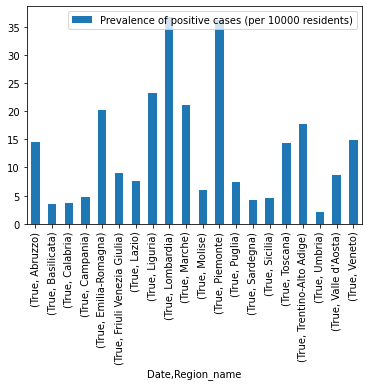

In [18]:
regional_prevalence_table.plot(kind='bar')

The highest prevalence has been reached in Piemonte and Lombardia.

Now we check the distribution of the indicator:

In [19]:
mean=np.nanmean(regional_prevalence_table) 
print("The mean is:",mean)
variance=np.var(regional_prevalence_table) 
print("The variance is:", variance)
skewness=stats.skew(regional_prevalence_table, nan_policy="omit")
print("The skewness of the distribution is:",skewness)

The mean is: 13.05380841934986
The variance is: Prevalence of positive cases (per 10000 residents)    100.889813
dtype: float64
The skewness of the distribution is: [1.10242689]


Now we do a density plot of the distribution of the indicator:

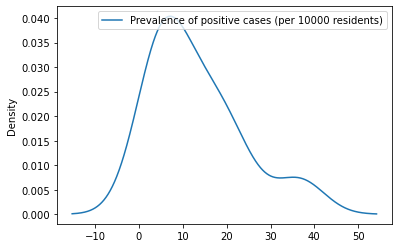

In [20]:
regional_prevalence_table.plot(kind="density")
plt.legend(loc=1)

We hence test for the skewness. <br>
H0: skewness of a Normal distribution

In [21]:
skewtest=stats.skewtest(regional_prevalence_table, nan_policy="omit") 
print("the p-value is:",skewtest[1][0])

the p-value is: 0.02474605451561196


Hence we reject the null hypothesis.

<a id='3b'></a>
### 3b. Week regional trend

We consider the week from the 27th of April to the 3rd of May. <br>
To take into consideration just that week we need to create a mask and "select" only the rows corresponding to the the week to analyze:

In [22]:
covid_regions_2020_modified['Date_new'] = pd.to_datetime(covid_regions_2020_modified['Date'])

In [23]:
mask = (covid_regions_2020_modified['Date_new'] >= "2020-04-27") & (covid_regions_2020_modified['Date_new'] < "2020-05-04")
covid_regions_2020_modified_week = covid_regions_2020_modified.loc[mask]

In [24]:
covid_regions_2020_modified_week.head()

Date     Region_name  Year  Region_code  Hospitalyzed_symptoms  \
1260  2020-04-27         Abruzzo  2020           13                    328   
1261  2020-04-27      Basilicata  2020           17                     57   
1262  2020-04-27        Calabria  2020           18                    114   
1263  2020-04-27        Campania  2020           15                    541   
1264  2020-04-27  Emilia-Romagna  2020            8                   2640   

      Intensive_care  Total_hospitalized  Home_isolation  Total_positive  \
1260              23                 351            1679            2030   
1261               7                  64             153             217   
1262               6                 120             662             782   
1263              37                 578            2299            2877   
1264             247                2887            9338           12225   

      Total_positive_variation  ...  Total_cases  swab_tests  Test_cases  \
1260                       -38  ...         2874       34176     26443.0   
1261                        -2  ...          366       10364     10364.0   
1262                       -15  ...         1096       31787     29834.0   
1263                       -47  ...         4349       68727     42463.0   
1264                      -116  ...        24662      164979    111041.0   

      Intensive_care_entrance  Total_positive_molecular_test  \
1260                      0.0                            0.0   
1261                      0.0                            0.0   
1262                      0.0                            0.0   
1263                      0.0                            0.0   
1264                      0.0                            0.0   

      Total_positive_rapid_test  Molecular_swab_test  Rapid_swab_text  \
1260                        0.0                  0.0              0.0   
1261                        0.0                  0.0              0.0   
1262                        0.0                  0.0              0.0   
1263                        0.0                  0.0              0.0   
1264                        0.0                  0.0              0.0   

      Total_population   Date_new  
1260         1293941.0 2020-04-27  
1261          553254.0 2020-04-27  
1262         1894110.0 2020-04-27  
1263         5712143.0 2020-04-27  
1264         4464119.0 2020-04-27  

[5 rows x 25 columns]

We check if we got the exact number of rows ( 7 observations for each of the 20 regions):

In [25]:
print("Shape:",covid_regions_2020_modified_week.shape)

Shape: (140, 25)


We now compute the indicator:

In [26]:
week_regional_trend_table = pd.crosstab(covid_regions_2020_modified_week['Region_name'], 
                                             values=100*covid_regions_2020_modified_week['Total_positive_variation']/covid_regions_2020_modified['Total_population'],
                                             aggfunc='sum',
                                            columns=['Week_regional_trend'])
week_regional_trend_table.columns.name=None
week_regional_trend_table

Week_regional_trend
Region_name                               
Abruzzo                          -0.015457
Basilicata                       -0.004519
Calabria                         -0.005016
Campania                         -0.003466
Emilia-Romagna                   -0.073833
Friuli Venezia Giulia            -0.013348
Lazio                            -0.003266
Liguria                           0.004656
Lombardia                         0.017552
Marche                           -0.007272
Molise                           -0.006322
Piemonte                          0.002760
Puglia                            0.000455
Sardegna                         -0.005833
Sicilia                           0.001969
Toscana                          -0.020067
Trentino-Alto Adige              -0.070867
Umbria                           -0.012986
Valle d'Aosta                    -0.115968
Veneto                           -0.037691

We do a bar plot of the week regional trend:

<AxesSubplot:xlabel='Region_name'>

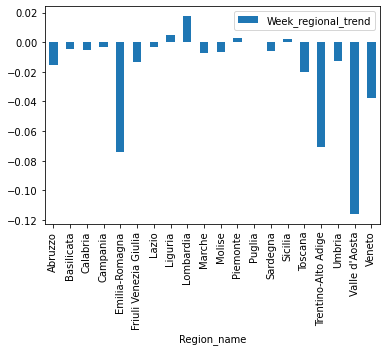

In [27]:
week_regional_trend_table.plot(kind='bar')

The increment has been the highest during the week in Lombardia while the decrement has been the highest in Valle d'Aosta.

Now we check the distribution of the indicator:

In [28]:
mean=np.nanmean(week_regional_trend_table) 
print("Mean:",mean)
variance=np.var(week_regional_trend_table) 
print("Variance:",variance)
skewness=stats.skew(week_regional_trend_table, nan_policy="omit") 
print("skewness",skewness)

Mean: -0.018425960689839083
Variance: Week_regional_trend    0.001004
dtype: float64
skewness [-1.80550377]


We do also a density plot:

<AxesSubplot:ylabel='Density'>

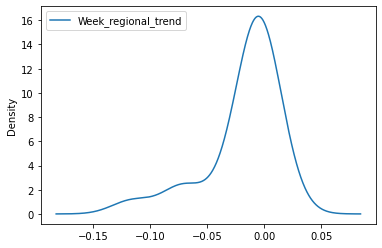

In [29]:
week_regional_trend_table.plot(kind="density")

And finally we test for the skewness:

In [30]:
skewtest=stats.skewtest(week_regional_trend_table, nan_policy="omit") #pvalue=array([0.00098048])
print("p-value",skewtest[1][0])

p-value 0.0009804759195920314


Also here we rejct the null hypothesis.

<a id='3c'></a>
### 3c. Tests performed

Now we compute the number of tests performed per 10,000 residents.

In [31]:
tests_table = pd.crosstab(covid_regions_2020_modified['Region_name'], 
                                             values=covid_regions_2020_modified['swab_tests']/covid_regions_2020_modified['Total_population']*10000,
                                             aggfunc='sum',
                                            columns=['Tests_performed'])
tests_table.columns.name=None
tests_table

Tests_performed
Region_name                           
Abruzzo                  395475.373298
Basilicata               336487.616899
Calabria                 249907.988448
Campania                 294161.411925
Emilia-Romagna           602421.169776
Friuli Venezia Giulia    791052.390285
Lazio                    406944.971072
Liguria                  491652.326233
Lombardia                511269.108008
Marche                   390016.295668
Molise                   368922.553208
Piemonte                 437940.716044
Puglia                   246969.831571
Sardegna                 281952.351080
Sicilia                  240229.785305
Toscana                  503881.816249
Trentino-Alto Adige      869644.493998
Umbria                   583607.695092
Valle d'Aosta            604408.001024
Veneto                   849807.939238

We check the bar plot:

<AxesSubplot:xlabel='Region_name'>

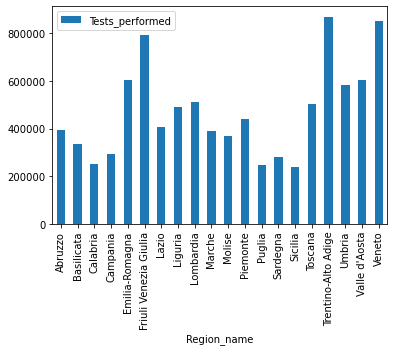

In [32]:
tests_table.plot(kind='bar')

The highest number of tests has been reached in Trentino-Alto Adige and Veneto.

We check the summary statistics:

In [33]:
mean=np.nanmean(tests_table) 
print("Mean:",mean)
variance=np.var(tests_table) 
print("Variance:",variance)
skewness=stats.skew(tests_table, nan_policy="omit") 
print("skewness",skewness)

Mean: 472837.6917211286
Variance: Tests_performed    3.604833e+10
dtype: float64
skewness [0.74013695]


And we check the density plot:

<AxesSubplot:ylabel='Density'>

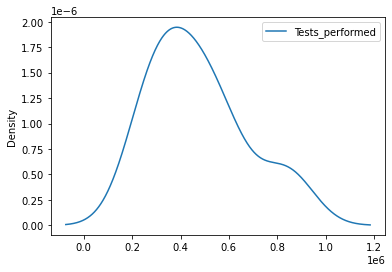

In [34]:
tests_table. plot(kind="density")

Finally we do a skewness test:

In [35]:
skewtest=stats.skewtest(tests_table, nan_policy="omit") #pvalue=array([0.00098048])
print("p-value",skewtest[1][0])

p-value 0.11334043427174784


We do not reject the null hypothesis.